In [7]:
"""
Single CSV Statistics Analysis

This notebook reads a single CSV file and provides the same statistics
as stats_data.py but for one year/file.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add parent directories to path
try:
    BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    if BASE_DIR not in sys.path:
        sys.path.insert(0, BASE_DIR)
except NameError:
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    if BASE_DIR not in sys.path:
        sys.path.insert(0, BASE_DIR)

DATA_DIR = os.path.join(BASE_DIR, 'data')

# Configuration: Set the year or file path here
YEAR = 1950  # Change this to analyze a different year
CSV_FILE = os.path.join(DATA_DIR, f'wikidata_movies_{YEAR}.csv')

print(f"Analyzing: {CSV_FILE}")
print(f"File exists: {os.path.exists(CSV_FILE)}")


Analyzing: /home/nab/GroupDataLiteracy/data/wikidata_movies_1950.csv
File exists: True


In [8]:
# Load the CSV file
df = pd.read_csv(CSV_FILE, dtype=str, low_memory=False)

print(f"Loaded {len(df)} movies")
print(f"Columns: {len(df.columns)}")
print(f"\nColumn names:")
print(df.columns.tolist())


Loaded 1523 movies
Columns: 22

Column names:
['movie_id', 'title', 'summary', 'release_date', 'genre', 'director', 'actors', 'duration', 'imdb_id', 'country', 'sitelinks', 'wikipedia_link', 'budget', 'box_office', 'awards', 'set_in_period', 'year', 'popularity', 'vote_average', 'vote_count', 'tmdb_id', 'plot']


In [9]:
def calculate_field_statistics(df, field):
    """Calculate statistics for a specific field."""
    if field not in df.columns:
        return {
            'total': len(df),
            'present': 0,
            'percentage': 0.0,
            'missing': len(df)
        }
    
    # Count non-null and non-empty values
    if df[field].dtype == 'object':
        present = df[field].notna() & (df[field].astype(str).str.strip() != '') & (df[field].astype(str) != 'nan')
    else:
        present = df[field].notna()
    
    count_present = present.sum()
    count_missing = len(df) - count_present
    percentage = (count_present / len(df) * 100) if len(df) > 0 else 0.0
    
    stats = {
        'total': len(df),
        'present': int(count_present),
        'percentage': round(percentage, 2),
        'missing': int(count_missing)
    }
    
    # For string fields, calculate average length
    if df[field].dtype == 'object' and count_present > 0:
        lengths = df[present][field].astype(str).str.len()
        stats['avg_length'] = round(lengths.mean(), 2)
        stats['min_length'] = int(lengths.min()) if len(lengths) > 0 else 0
        stats['max_length'] = int(lengths.max()) if len(lengths) > 0 else 0
    
    return stats

# Calculate and display field statistics
print("=" * 80)
print(f"FIELD STATISTICS FOR YEAR {YEAR}")
print("=" * 80)
print(f"Total movies: {len(df)}")
print("\nField Completeness:")
print("-" * 80)
print(f"{'Field':<25} {'Present':<10} {'Missing':<10} {'Percentage':<12} {'Avg Length':<12}")
print("-" * 80)

fields = [col for col in df.columns if col != 'year']
for field in fields:
    stats = calculate_field_statistics(df, field)
    avg_len = stats.get('avg_length', 'N/A')
    print(f"{field:<25} {stats['present']:<10} {stats['missing']:<10} {stats['percentage']:<12.2f}% {str(avg_len):<12}")

print("-" * 80)


FIELD STATISTICS FOR YEAR 1950
Total movies: 1523

Field Completeness:
--------------------------------------------------------------------------------
Field                     Present    Missing    Percentage   Avg Length  
--------------------------------------------------------------------------------
movie_id                  1523       0          100.00      % 8.32        
title                     1523       0          100.00      % 16.46       
summary                   0          1523       0.00        % N/A         
release_date              1523       0          100.00      % 20.0        
genre                     1318       205        86.54       % 17.43       
director                  1472       51         96.65       % 14.83       
actors                    1181       342        77.54       % 134.67      
duration                  1050       473        68.94       % 2.12        
imdb_id                   1492       31         97.96       % 9.01        
country           

In [10]:
# Analyze plots/summaries
print("=" * 80)
print("PLOT/SUMMARY ANALYSIS")
print("=" * 80)

total_movies = len(df)
print(f"Total movies: {total_movies}")

# Check for plot column first (preferred)
has_plot_column = 'plot' in df.columns
has_summary_column = 'summary' in df.columns

if not has_plot_column and not has_summary_column:
    print("No 'plot' or 'summary' column found in data")
else:
    # Use plot if available, otherwise use summary
    if has_plot_column:
        text_column = 'plot'
        text_type = 'Plot'
        text_type_plural = 'plots'
    else:
        text_column = 'summary'
        text_type = 'Summary'
        text_type_plural = 'summaries'
    
    # Check for plots/summaries (non-null and non-empty)
    has_text = df[text_column].notna() & (df[text_column].astype(str).str.strip() != '') & (df[text_column].astype(str) != 'nan')
    text_count = has_text.sum()
    
    print(f"Movies with {text_type_plural}: {text_count} ({text_count/total_movies*100:.2f}%)")
    print(f"Movies without {text_type_plural}: {total_movies - text_count} ({(total_movies - text_count)/total_movies*100:.2f}%)")
    
    # Also show summary stats if both columns exist
    if has_plot_column and has_summary_column:
        has_summary = df['summary'].notna() & (df['summary'].astype(str).str.strip() != '') & (df['summary'].astype(str) != 'nan')
        summary_count = has_summary.sum()
        print(f"\nMovies with summaries: {summary_count} ({summary_count/total_movies*100:.2f}%)")
    
    if text_count > 0:
        # Calculate text lengths
        texts = df[has_text][text_column].astype(str)
        text_lengths = texts.str.len()
        
        print(f"\n{text_type} Length Statistics:")
        print(f"  Average length: {text_lengths.mean():.2f} characters")
        print(f"  Median length: {text_lengths.median():.2f} characters")
        print(f"  Min length: {text_lengths.min()} characters")
        print(f"  Max length: {text_lengths.max()} characters")
        print(f"  Standard deviation: {text_lengths.std():.2f} characters")


PLOT/SUMMARY ANALYSIS
Total movies: 1523
Movies with plots: 1393 (91.46%)
Movies without plots: 130 (8.54%)

Movies with summaries: 0 (0.00%)

Plot Length Statistics:
  Average length: 1034.30 characters
  Median length: 448.00 characters
  Min length: 19 characters
  Max length: 12490 characters
  Standard deviation: 1217.60 characters


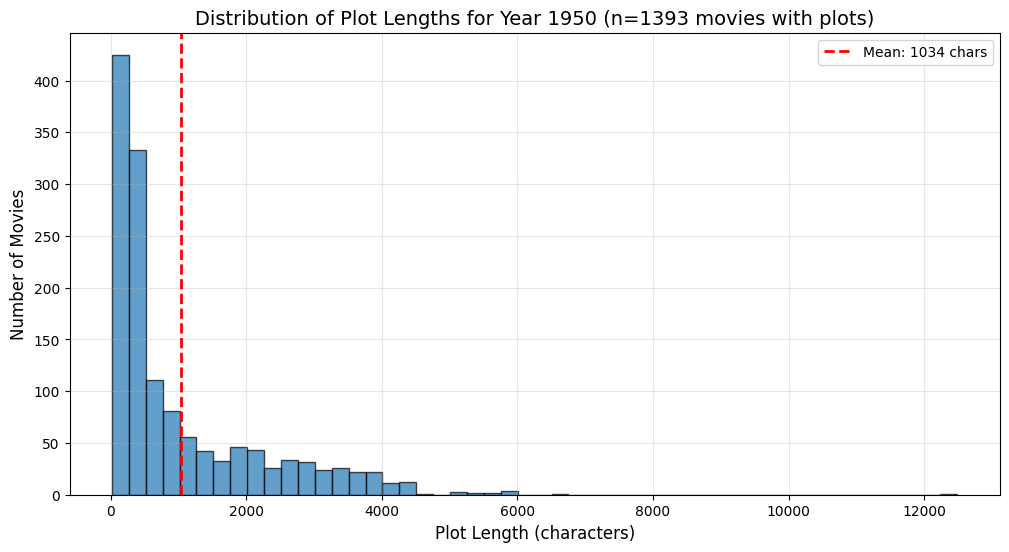

In [11]:
# Create histogram of plot/summary lengths
if has_plot_column or has_summary_column:
    if text_count > 0:
        plt.figure(figsize=(12, 6))
        plt.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel(f'{text_type} Length (characters)', fontsize=12)
        plt.ylabel('Number of Movies', fontsize=12)
        plt.title(f'Distribution of {text_type} Lengths for Year {YEAR} (n={text_count} movies with {text_type_plural})', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # Add vertical line for mean
        mean_length = text_lengths.mean()
        plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.0f} chars')
        plt.legend()
        plt.show()
    else:
        print("No plots/summaries available for histogram")
else:
    print("No plot or summary column available for histogram")


In [12]:
# Display first few rows for inspection
print("=" * 80)
print("SAMPLE DATA (first 3 rows)")
print("=" * 80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)
display(df.head(3))


SAMPLE DATA (first 3 rows)


,movie_id,title,summary,release_date,genre,director,actors,duration,imdb_id,country,sitelinks,wikipedia_link,budget,box_office,awards,set_in_period,year,popularity,vote_average,vote_count,tmdb_id,plot
0,Q191753,Cinderella,NaN,1950-02-15T00:00:00Z,"musical, fantasy film, melodrama, musical film, romance film, family film, cinematic fairy tale","Clyde Geronimi, Hamilton Luske, Wilfred Jackson",NaN,74,tt0042332,United States,103,https://en.wikipedia.org/wiki/Cinderella_(1950_film),2200000,93141149,Golden Bear,19th century,1950,10.3299,7.045,6958,11224,Cinderella is the daughter of a widowed aristocrat living in the small but prosperous French kin...
1,Q200299,All About Eve,NaN,1950-01-01T00:00:00Z,"drama film, comedy film, film based on literature",Joseph L. Mankiewicz,"Marilyn Monroe, Bette Davis, Barbara Bates, Celeste Holm, Anne Baxter, Thelma Ritter, George San...",138,tt0042192,United States,68,https://en.wikipedia.org/wiki/All_About_Eve,1400000,8400000,"Academy Award for Best Picture, Academy Award for Best Director, Academy Award for Best Supporti...",NaN,1950,3.9591,8.1,1618,705,"At the Sarah Siddons Award ceremony honoring rising actress Eve Harrington, narration from acerb..."
2,Q135465,Rashomon,NaN,1950-08-25T00:00:00Z,"drama film, samurai cinema, crime film, medieval film, flashback film",Akira Kurosawa,"Toshirō Mifune, Takashi Shimura, Machiko Kyō, Minoru Chiaki, Masayuki Mori",88,tt0042876,Japan,62,https://en.wikipedia.org/wiki/Rashomon,140000,NaN,"Golden Lion, Academy Honorary Award",Heian period,1950,6.2216,8.046,2399,548,"In Heian-era Kyoto, a woodcutter and a Buddhist monk, taking shelter from a downpour under the R..."


In [13]:
# Verify comma handling in plot field
print("=" * 80)
print("COMMA HANDLING VERIFICATION")
print("=" * 80)

if has_plot_column and text_count > 0:
    # Find plots with commas
    plots_with_commas = df[has_text & df[text_column].astype(str).str.contains(',', na=False)]
    comma_count = len(plots_with_commas)
    
    print(f"Total plots: {text_count}")
    print(f"Plots containing commas: {comma_count} ({comma_count/text_count*100:.2f}%)")
    
    if comma_count > 0:
        print("\nSample plots with commas (verifying text continues after comma):")
        print("-" * 80)
        
        for idx, (i, row) in enumerate(plots_with_commas.head(3).iterrows()):
            plot = str(row[text_column])
            first_comma = plot.find(',')
            text_after_comma = plot[first_comma+1:first_comma+101].strip()
            
            print(f"\nSample {idx+1}: {row.get('title', 'N/A')}")
            print(f"  Full length: {len(plot)} characters")
            print(f"  First comma at position: {first_comma}")
            print(f"  Text before comma: {plot[:min(50, first_comma)]}...")
            print(f"  Text after comma: ...{text_after_comma}...")
            
            if len(text_after_comma) > 0:
                print("  ✓ Comma handled correctly - text continues")
            else:
                print("  ✗ WARNING: No text after comma!")
        
        print("\n" + "=" * 80)
        print("CONCLUSION: Commas are being handled correctly!")
        print("=" * 80)
        print("\nExplanation: The CSV is saved using pandas' default quoting")
        print("(QUOTE_MINIMAL), which automatically quotes fields containing")
        print("commas. This ensures commas within text are preserved correctly.")
    else:
        print("\nNo plots with commas found to verify.")
else:
    print("No plot column available for verification.")



COMMA HANDLING VERIFICATION
Total plots: 1393
Plots containing commas: 1200 (86.15%)

Sample plots with commas (verifying text continues after comma):
--------------------------------------------------------------------------------

Sample 1: Cinderella
  Full length: 3764 characters
  First comma at position: 121
  Text before comma: Cinderella is the daughter of a widowed aristocrat...
  Text after comma: ...her father remarries Lady Tremaine, a widow with two daughters of her own, Anastasia and Drizella,...
  ✓ Comma handled correctly - text continues

Sample 2: All About Eve
  Full length: 4282 characters
  First comma at position: 74
  Text before comma: At the Sarah Siddons Award ceremony honoring risin...
  Text after comma: ...narration from acerbic theatre critic Addison DeWitt introduces the attendees and hints that there...
  ✓ Comma handled correctly - text continues

Sample 3: Rashomon
  Full length: 3996 characters
  First comma at position: 18
  Text before comma: In Hei

## Notes

- Change `YEAR` in the first cell to analyze a different CSV file
- Or modify `CSV_FILE` to point to a specific file path
- The statistics match the format used in `stats_data.py`
- Field statistics show completeness percentages and average lengths (for string fields)
- Plot/Summary analysis shows counts and length distributions
